C:\Users\312MY\AppData\Local\Temp\ipykernel_47144\2667401142.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(thrust_profile([t], thrust_burn_time, thrust_ramp_up_time, thrust_ramp_down_time, thrust_total_impulse))


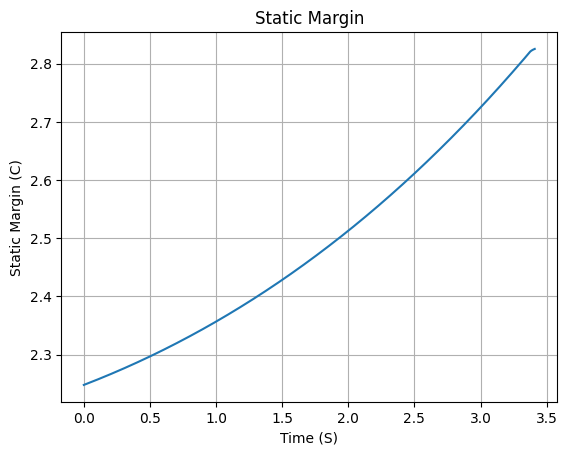

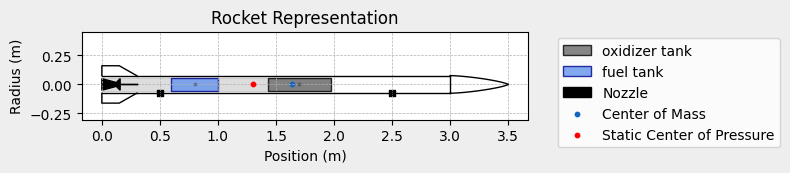


Apogee State

Apogee Time: 21.900 s
Apogee Altitude: 2239.541 m (ASL) | 2201.798 m (AGL)
Apogee Freestream Speed: 53.001 m/s
Apogee X position: 19.478 m
Apogee Y position: 896.621 m
Apogee latitude: 51.4174444°
Apogee longitude: 0.6423731°
Max Acceleration reached: 77.15 m/s²


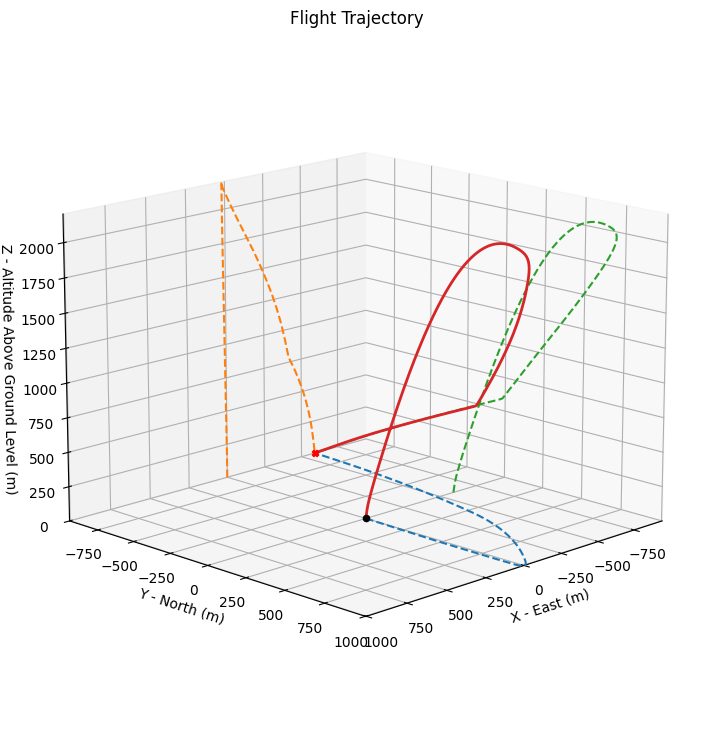

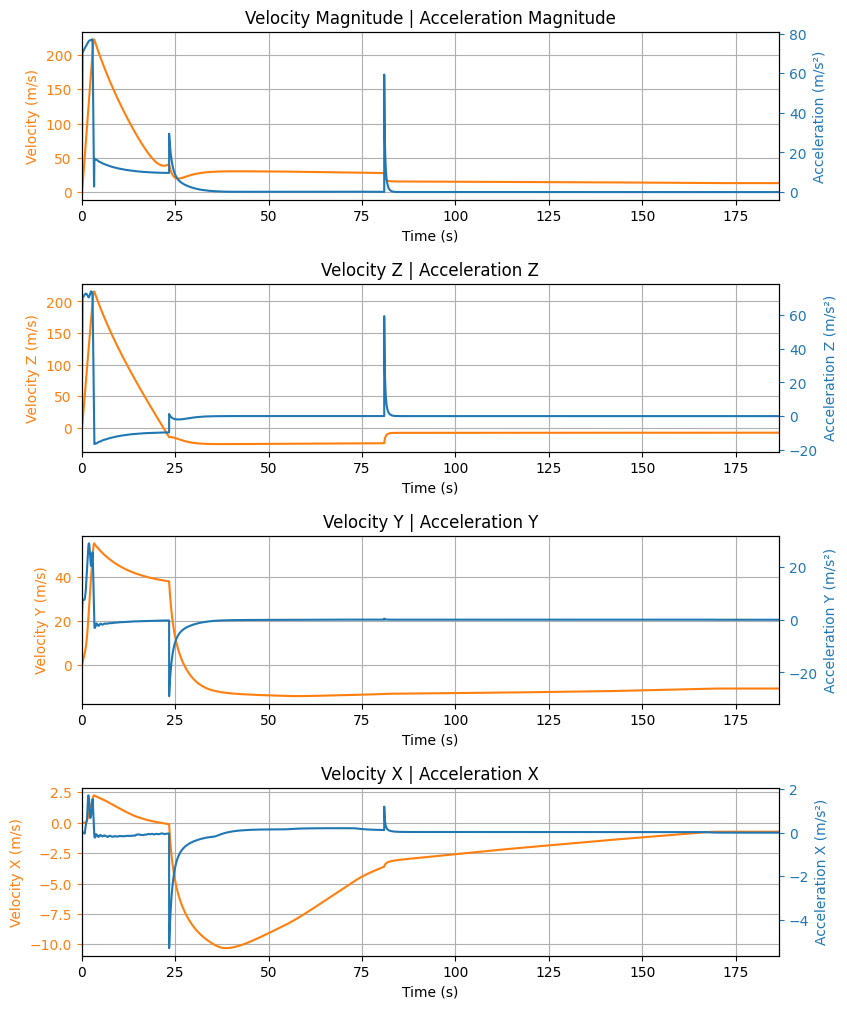

In [1]:
# Importing the libraries
# Import RocketPy classes
from rocketpy import Flight, Environment, Rocket, LiquidMotor, Fluid, CylindricalTank, MassFlowRateBasedTank
from datetime import datetime,timedelta

import numpy as np
import matplotlib.pyplot as plt


# RocketPy single file rocket simulation script with a thrust profile generator
# These parameters can be adjusted to define the rocket, motor, and environment.
# If your are running this for the first time, please install required packages:
#   pip install rocketpy numpy matplotlib
# Just type the command in your terminal/command prompt.
# ------------------------------------------------------------------------

# -------------------- PARAMETERS (EDIT THESE) ---------------------------
# Location & launch time
latitude = 51.40937342760082            # degrees (positive north)
longitude = 0.6420919634187094           # degrees (positive east)
elevation_m = 10.0         # meters above sea level
# Launch date will be set to tomorrow's date in the main code - this ensures accurate atmospheric data (can be changed but requires RocketPy knowledge)

# Rocket general properties (from Rocket class)
rocket_radius_m = 0.076         # m (body radius)
rocket_mass_kg = 20.0         # kg (total without motor if appropriate)
rocket_inertia_kgm2 = (6.001, 1.001, 0.001)  # [Ixx, Iyy, Izz] or scalar
rocket_com_no_motor_m = 2.5 # meters from bottom of rocket
burn_time = 3.41

# Nose cone parameters
nose_length_m = 0.5
nose_shape = 'von karman'   # 'ogive', 'conical', 'parabolic', ...
nose_cone_position = 3.5  # meters from bottom of rocket

# Fins parameters
num_fins = 4
fin_root_chord_m = 0.3
fin_tip_chord_m = 0.15
fin_span_m = 0.085
fin_position = 0.3  # meters from bottom of rocket
fin_cant_angle = 0.5

# Parachute parameters (drogue + main)
drogue_cd = 1
drogue_trigger = 'apogee'  # meters altitude
drogue_lag_time_s = 1.5 # seconds delay after trigger

main_cd = 10
main_trigger = 800  # meters altitude
main_lag_time_s = 0.0  # seconds delay after trigger

# Tank parameters
tank_radius = 0.0535  # meters
fuel_tank_height = 0.400  # meters
oxidizer_tank_height = 0.540  # meters
burn_time = 3.41  # seconds (total burn duration)
total_propellant_mass = 7.2  # kg (total propellant mass)
OF_ratio = 1.16  # Oxidizer to Fuel ratio

# Motor parameters
motor_dry_mass = 15  # kg
nozzle_radius = 0.05  # meters
center_of_dry_mass_position = 0.7  # meters from bottom of motor
oxidizer_tank_position = 1.7  # meters from bottom of motor
fuel_tank_position = 0.8  # meters from bottom of motor
total_impulse = 10240.0  # Newton-seconds
motor_dry_inertia = (0.125, 0.125, 0.002)  # [Ixx, Iyy, Izz] or scalar

# Thrust profile parameters (ramp times and total impulse)
thrust_burn_time = burn_time     # seconds total burn time
thrust_ramp_up_time = 0.2                # seconds (time to ramp from 0 to plateau)
thrust_ramp_down_time = 0.5              # seconds (time to ramp from plateau to 0)
thrust_total_impulse = total_impulse  # Newton-seconds (area under thrust curve)

# Launch rail parameters
rail_length_m = 15.0  # meters
inclination_deg = 84.0  # degrees from vertical
heading_deg = 0.0  # degrees from north

# Time settings for simulation/plots
dt = 0.01   # time step for thrust calculation and plots (s)

# ------------------------------------------------------------------------
# Imports and helper functions
# ------------------------------------------------------------------------

def thrust_profile(t_array, burn_time, ramp_up, ramp_down, total_impulse):
    """
    Generate a thrust time-history (N) over times t_array for a burn described by:
      - burn_time: total time from ignition to extinguish [s]
      - ramp_up: time from 0 to plateau [s]
      - ramp_down: time from plateau to 0 [s]
      - total_impulse: desired integral of thrust over time [N*s]
    The plateau duration is computed so that ramp_up + plateau + ramp_down = burn_time.
    The trapezoidal profile is scaled so its area equals total_impulse.
    Returns an array of thrust (N) matching t_array shape.
    """
    t_array = np.asarray(t_array, dtype=float)
    if burn_time <= 0:
        return np.zeros_like(t_array)

    ramp_up = float(ramp_up)
    ramp_down = float(ramp_down)
    burn_time = float(burn_time)

    # Ensure ramps do not exceed burn_time; if they do, scale them down proportionally
    max_ramps = ramp_up + ramp_down
    if max_ramps >= burn_time:
        if max_ramps == 0:
            plateau = 0.0
            ramp_up = ramp_down = 0.0
        else:
            scale = (burn_time * 0.999) / max_ramps
            ramp_up *= scale
            ramp_down *= scale
            plateau = burn_time - (ramp_up + ramp_down)
    else:
        plateau = burn_time - (ramp_up + ramp_down)

    # Analytical area of unscaled trapezoid (peak = 1): plateau + 0.5*ramp_up + 0.5*ramp_down
    area_unscaled = plateau + 0.5 * ramp_up + 0.5 * ramp_down
    if area_unscaled <= 0:
        return np.zeros_like(t_array)

    # scale factor to get desired impulse
    scale = float(total_impulse) / area_unscaled

    # Build thrust array
    thrust = np.zeros_like(t_array)
    # Fill vectorized
    for i, t in enumerate(t_array):
        if t < 0 or t > burn_time:
            val = 0.0
        elif t <= ramp_up:
            val = (t / ramp_up) if ramp_up > 0 else 1.0
        elif t <= ramp_up + plateau:
            val = 1.0
        else:
            td = t - (ramp_up + plateau)
            val = max(0.0, 1.0 - td / ramp_down) if ramp_down > 0 else 0.0
        thrust[i] = val * scale

    return thrust

# ------------------------------------------------------------------------
# Example usage: compute and plot thrust curve for current parameters
# ------------------------------------------------------------------------
time_array = np.arange(0.0, thrust_burn_time + dt, dt)
thrust_array = thrust_profile(time_array,
                              burn_time=thrust_burn_time,
                              ramp_up=thrust_ramp_up_time,
                              ramp_down=thrust_ramp_down_time,
                              total_impulse=thrust_total_impulse)

# Create a thrust function suitable for RocketPy
def thrust_curve_scalar(t):
    return float(thrust_profile([t], thrust_burn_time, thrust_ramp_up_time, thrust_ramp_down_time, thrust_total_impulse))

"""
# Quick diagnostic: check area under curve vs requested total_impulse
calculated_impulse = np.trapz(thrust_array, time_array)
print(f"Requested total impulse: {thrust_total_impulse:.3f} N*s")
print(f"Calculated impulse (numerical): {calculated_impulse:.6f} N*s")

# Plot thrust vs time
plt.figure(figsize=(8,4))
plt.plot(time_array, thrust_array)
plt.xlabel('Time (s)')
plt.ylabel('Thrust (N)')
plt.title('Thrust vs Time (trapezoidal profile)')
plt.grid(True)
plt.tight_layout()
plt.show()
"""
# ------------------------------------------------------------------------
# Main RocketPy code section
# ------------------------------------------------------------------------


# ------------------------------------------------------------------------

# # Create environment
env = Environment(
    latitude=latitude,
    longitude=longitude,
    elevation=elevation_m
)
# Set the date to tomorrow for the environment to get accurate atmospheric data 
tomorrow = datetime.now() + timedelta(days=1)

env.set_date(
    (tomorrow.year, tomorrow.month, tomorrow.day, 12)
)  # Hour given in UTC time

env.set_atmospheric_model(type="Forecast", file="GFS")



# Multiple various weather data sources are available, here we use ISA


# ------------------------------------------------------------------------

# Define Propellants
Nox_liq = Fluid(name="NOX", density=1226.0)     # liquid nitrous oxide ~1226 kg/m^3
Nox_gas = Fluid(name="N2O_g", density=1.977)    # N2O gas density at STP ~1.977 kg/m^3
Ethanol_liq = Fluid(name="Ethanol_l", density=860.0)  # liquid ethanol ~860 kg/m^3
Ethanol_gas = Fluid(name="Ethanol_g", density=1.59)   # ethanol gas density at STP ~1.59 kg/m^3

# ------------------------------------------------------------------------

# Create constant mass flow rate profiles for the tanks
fuel_mass = total_propellant_mass / (OF_ratio + 1)
oxidizer_mass = total_propellant_mass - fuel_mass
oxidizer_mass_flow_out = lambda t: (oxidizer_mass / burn_time) if (0.0 <= t < burn_time) else 0.0
fuel_mass_flow_out = lambda t: (fuel_mass / burn_time) if (0.0 <= t < burn_time) else 0.0

# ------------------------------------------------------------------------

# Create tanks

oxidizer_tank = MassFlowRateBasedTank(
    name="oxidizer tank",
    geometry=CylindricalTank(radius=tank_radius, height=oxidizer_tank_height, spherical_caps=False),
    flux_time=burn_time,
    initial_liquid_mass=oxidizer_mass,
    initial_gas_mass=0.001,
    liquid_mass_flow_rate_in=0,
    liquid_mass_flow_rate_out=oxidizer_mass_flow_out,
    gas_mass_flow_rate_in=0,
    gas_mass_flow_rate_out=0,
    liquid=Nox_liq,
    gas=Nox_gas,
)

fuel_tank = MassFlowRateBasedTank(
    name="fuel tank",
    geometry=CylindricalTank(radius=tank_radius, height=fuel_tank_height, spherical_caps=False),
    flux_time=burn_time,
    initial_liquid_mass=fuel_mass,
    initial_gas_mass=0.001,
    liquid_mass_flow_rate_in=0,
    liquid_mass_flow_rate_out=fuel_mass_flow_out,
    gas_mass_flow_rate_in=0,
    gas_mass_flow_rate_out=0,
    liquid=Nox_liq,
    gas=Nox_gas,
)

# ------------------------------------------------------------------------

# Create motor using parameters defined above
liquidmotor = LiquidMotor(
    thrust_source=thrust_curve_scalar,
    dry_mass= motor_dry_mass,
    dry_inertia= motor_dry_inertia,
    nozzle_radius= nozzle_radius,
    center_of_dry_mass_position= center_of_dry_mass_position,
    nozzle_position=0,
    burn_time=burn_time,
    coordinate_system_orientation="nozzle_to_combustion_chamber",
)

liquidmotor.add_tank(tank=oxidizer_tank, position= oxidizer_tank_position)
liquidmotor.add_tank(tank=fuel_tank, position= fuel_tank_position)

# ------------------------------------------------------------------------
# Creating/importing the rocket drag profile
"""
#Code for creating simple constant drag curves for testing

CD_off = 0.4 * np.ones(50)  # Constant drag coefficient for power-off
CD_on = 0.42 * np.ones(50)   # Constant drag coefficient for
Mach = np.linspace(0, 1.5, 50)  # Mach numbers from 0 to 1.5
# Create the drag curves in the required format for Rocket
Curve_off = np.column_stack((Mach, CD_off))
Curve_on = np.column_stack((Mach, CD_on))
"""
#OR directly importing the drag curves from a csv file
CD_data = np.loadtxt('2m CD Profile.csv', delimiter=',')

#OpenRocket exports the data in the incorrect format so we need to switch the columns
#RocketPy requires the first column to be Mach number and the second column to be CD
CD_off = CD_data[1:, ::-1]
#Cleaning the data by removing all values after max mach number of 1.5 and any CD values above 1
CD_off = CD_off[CD_off[:,0] <= 1.7]
CD_off = CD_off[CD_off[:,1] <= 1.0]

CD_on = CD_off + 0.02  # Example modification for power-on drag curve
Mach = CD_off[:, 0]
# ------------------------------------------------------------------------

# Create Rocket and assign geometry/inertia/CoM parameters:
Hermes = Rocket(
    radius = rocket_radius_m, 
    mass = rocket_mass_kg, 
    inertia = rocket_inertia_kgm2, 
    center_of_mass_without_motor = rocket_com_no_motor_m, 
    power_off_drag= CD_off, #Drag curve when the rocket engine is off
    power_on_drag= CD_on, #Drag curve when the rocket engine is on
    coordinate_system_orientation="tail_to_nose",  #Orientation of the rocket coordinate system this is saying the tail is at position 0 and the nose is at position 1
    )


Hermes.add_motor(liquidmotor, position=0)

# Setting rail buttons position
rail_buttons = Hermes.set_rail_buttons(
    upper_button_position= 2.5,
    lower_button_position=0.5,
    angular_position=45, 
)


# Adding nose cone, fins, parachutes using the parameter variables defined above
nose = Hermes.add_nose(
    length = nose_length_m,
    kind = nose_shape,
    position = nose_cone_position
)
    

fins = Hermes.add_trapezoidal_fins(
    n = num_fins,
    root_chord = fin_root_chord_m,
    tip_chord = fin_tip_chord_m,
    span = fin_span_m,
    position = fin_position,
    cant_angle = fin_cant_angle,
)

drogue = Hermes.add_parachute(
    name = "drogue",
    lag = drogue_lag_time_s,
    trigger = drogue_trigger,
    cd_s = drogue_cd,
)

main = Hermes.add_parachute(
    name = "main",
    lag = main_lag_time_s,
    trigger = main_trigger,
    cd_s = main_cd,
)

# ------------------------------------------------------------------------
# Run the simulation
Tothemoon = Flight(
    rocket = Hermes,
    environment=env,
    rail_length=rail_length_m,
    inclination=inclination_deg,
    heading=heading_deg,
)

# Printing the needed information about the rocket flight
#Static margin at launch
Hermes.plots.static_margin()
#Draw rocket
Hermes.draw()

# Apogee information
# Apogee conditions
Tothemoon.prints.apogee_conditions()

#Environment information
# env.info()



print(f"Max Acceleration reached: {Tothemoon.max_acceleration:.2f} m/s²")

# 3D trajectory plot
Tothemoon.plots.trajectory_3d()
# Kinematics plot (altitude, velocity, acceleration vs time)
Tothemoon.plots.linear_kinematics_data()



# All flight information
# Tothemoon.all_info()
